In [32]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
color_sns = sns.cubehelix_palette(8, start=.5, rot=-.75)

# Rocksdb

/tmp/ipykernel_970966/4263589239.py:28: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(10)


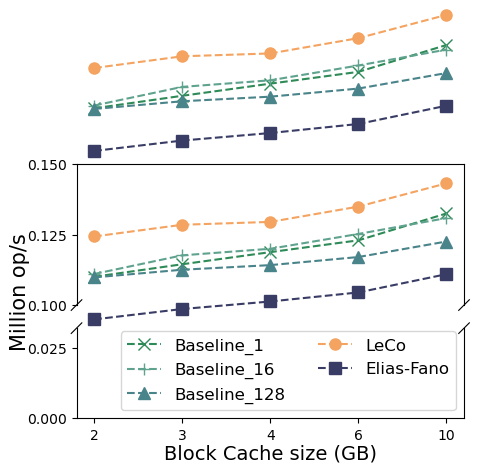

In [33]:
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from brokenaxes import brokenaxes
Baseline = [0.110038,0.114483,0.118789,0.122976,0.132508]
Baseline_16=[0.111025,0.117650,0.119981,0.125244,0.130878]
Baseline_128 = [0.109812,0.112544,0.114175,0.117051,0.122561]
Leco=[0.124348,0.128505,0.129521,0.134952,0.143202]
FOR=[0.109088,0.113897,0.117474,0.124294,0.132217]
EF = [0.094909, 0.098598, 0.101269, 0.104480, 0.110961]
label = ['Baseline_1','Baseline_16','Baseline_128','LeCo','Elias-Fano']
dataset = [Baseline, Baseline_16,Baseline_128,Leco,EF]
mark_style = ['x','+','^','o','s']
# colors = ['sandybrown','lightseagreen','seagreen', 'slategray']
colors =  ['seagreen',color_sns[3],color_sns[4],'sandybrown',color_sns[6]]
plt.figure(figsize=(5, 3.3))
bax = brokenaxes( ylims=[(0, 0.032), (0.1, 0.15)], despine=False)
for i in range(len(dataset)):
    bax.plot(dataset[i],ls='--',marker=mark_style[i],label = label[i], c = colors[i],ms=8,clip_on=False)

bax.set_ylabel('Million op/s',fontsize=15)
bax.set_xlabel('Block Cache size (GB)',fontsize=14)
# plt.title('Rocksdb index block',fontsize=23)
# plt.ylim([0,0.16])
bax.set_xticks([0,1,2,3,4],['2','3','4','6','10'], fontsize=10)
# bax.set_yticks(fontsize=10)
for i in range(2):
    for tick in bax.axs[i].get_yaxis().get_major_ticks():
        tick.label.set_fontsize(10)
bax.legend(fontsize=12, loc=4, ncol = 2)
# plt.tight_layout()
# plt.subplots_adjust(left=0.12, right=0.97, bottom=0.2, top=0.95)
plt.savefig("Rocksdb.pdf", bbox_inches='tight', pad_inches=0.05, transparent=True)
# plt.savefig('Rocksdb.pdf',dpi=500, transparent=True)
plt.show()


# Parquet

scale: linear


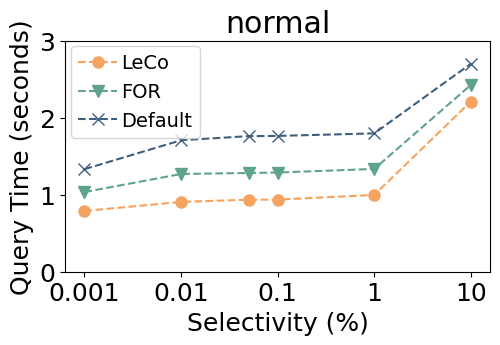

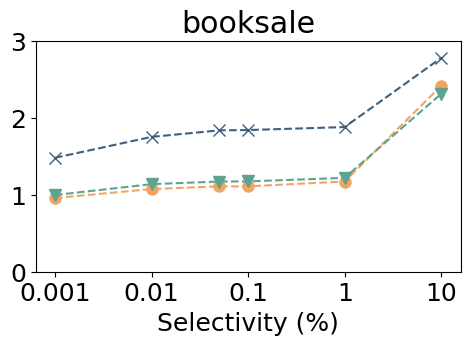

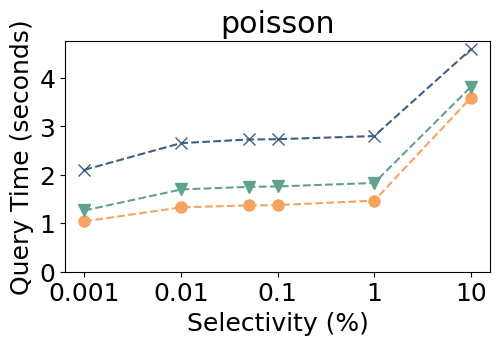

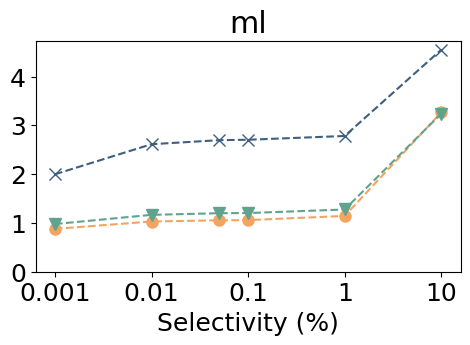

In [2]:
from curses.panel import bottom_panel
from logging import StrFormatStyle

PROJ_SRC_DIR = '/root/arrow-private/cpp'
name = 'i3g_new.csv'

matplotlib.rcParams.update({'font.size': 18})
from matplotlib.ticker import *

df = pd.read_csv(name) 
df_avg = df.groupby(['dataset', 'encoding','selectivity'], as_index=False).mean().set_index(['dataset','encoding'])

df_avg = df_avg.drop(['PLAIN'], axis=0, level=1)
dataset_dict = set()
encoding_dict = set()
for i, row in df_avg.iterrows():   
    dataset_dict.add(i[0])
    encoding_dict.add(i[1])

dataset_dict = ['normal_200M_uint32.txt', 'books_200M_uint32.txt',
 'poisson_timestamps_EVENT_50000_SENSOR_2000_randomdie_OUTER_1000s_INNER_2ms_200M.csv', 'ml_timestamp_200M.csv']

scale = ['linear']
ds_to_title = {'linear_200M_uint32.txt': 'linear', 'books_200M_uint32.txt': 'booksale',
 'wiki_200M_uint64': 'wiki', 'normal_200M_uint32.txt': 'normal', 'ml_timestamp_200M.csv': 'ml', 
 'poisson_timestamps_EVENT_50000_SENSOR_2000_randomdie_OUTER_1000s_INNER_2ms_200M.csv': 'poisson'}
enc_to_label = {'LECO': 'LeCo', 'FOR': 'FOR', 'DICT': 'Default', 'PLAIN': 'Plain'}
encoding_dict = ['LECO','FOR','DICT']
marker = ['o','v','x']
colors = ['sandybrown',color_sns[3],color_sns[5]]

for s in scale:
    print(f'scale: {s}')
    cnt = 0
    for ds in dataset_dict:
        fig, ax = plt.subplots(figsize=(5, 3.3))
        for i, enc in enumerate(encoding_dict):
            ax.plot(df_avg.loc[ds, enc]['selectivity'], df_avg.loc[ds, enc]['query_time'], label=enc_to_label[enc], marker=marker[i], color=colors[i], ls='--', ms=8)
        
        # speedup txt code, should comment off
        # speedup_over_default = df_avg.loc[ds, 'DICT']['query_time'].values / df_avg.loc[ds, 'LECO']['query_time'].values
        # speedup_over_for = df_avg.loc[ds, 'FOR']['query_time'].values / df_avg.loc[ds, 'LECO']['query_time'].values
        # speedup_xspace, speedup_yspace = 0, 0.1
        # print(speedup_over_default)
        # print(speedup_over_for)
        # for x, y, s in zip(df_avg.loc[ds, 'DICT']['selectivity'], df_avg.loc[ds, 'DICT']['query_time'], speedup_over_default):
        #     ax.text(x + speedup_xspace, y + speedup_yspace, "%.1fx"%(s), fontsize=12)
        
        # for x, y, s in zip(df_avg.loc[ds, 'FOR']['selectivity'], df_avg.loc[ds, 'FOR']['query_time'], speedup_over_for):
        #     ax.text(x + speedup_xspace, y + speedup_yspace, "%.1fx"%(s), fontsize=12)

        # ax.set_yscale(s)
        ax.set_xscale('log')
        ax.set_xticks([0.001, 0.01, 0.1, 1.0, 10])
        if cnt == 0 or cnt == 1:
            ax.set_yticks([0, 1, 2, 3])
        else:
            ax.set_yticks([0, 1, 2, 3, 4])
        ax.xaxis.set_major_formatter('{x:g}')
        ax.set_ylim(bottom=0)
        if cnt == 0:
            ax.legend(loc="upper left", bbox_to_anchor=((-0.01,1.02)), ncol=1, frameon=True,
                        prop={'size': 14}, columnspacing=1, handletextpad=0.2)
        ax.set_xlabel('Selectivity (%)')
        if cnt % 2 == 0:
            ax.set_ylabel('Query Time (seconds)')
        # ax.set_title(ds_to_title[ds])
        # plt.tight_layout()
        plt.title(ds_to_title[ds])
        plt.subplots_adjust(left=0.12, right=0.97, bottom=0.2, top=0.9)
        plt.savefig(f'leco_pq_{ds_to_title[ds]}.pdf')
        plt.show()
        cnt += 1

## Parquet Filter Scan

In [34]:
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
category_colors = [color_sns[5],color_sns[3],color_sns[1],'sandybrown','peachpuff']
def plot_filter_bar(sync_dict, sync_FOR, sync_LECO, IO_dict, IO_FOR, IO_LECO, titlename,withylabel=1, withxlabel=1):
    selectivity = [0.001, 0.01, 0.1, 1, 10]
    mark_style = ['o','v']
    X = np.arange(len(selectivity))+1
    fig, ax = plt.subplots(figsize=(5.5, 3))
    bar_width = 0.27
    plt.bar(X-0.3, sync_dict-IO_dict,bottom=IO_dict, label = "Default_CPU",width = bar_width, color = color_sns[5], hatch='//',ec=color_sns[7])
    plt.bar(X-0.3, IO_dict, label = "Default_IO",width = bar_width, color = color_sns[4],ec=color_sns[5])
    plt.bar(X, sync_FOR-IO_FOR,bottom=IO_FOR, label = "FOR_CPU",width = bar_width, color = color_sns[3], hatch='\\\\',ec=color_sns[4])
    plt.bar(X, IO_FOR, label = "FOR_IO" ,width = bar_width,  color = color_sns[1], ec=color_sns[2])
    plt.bar(X+0.3, sync_LECO-IO_LECO,bottom=IO_LECO, label = "LeCo_CPU",width = bar_width, color = category_colors[-2], hatch='//',ec='chocolate')
    plt.bar(X+0.3, IO_LECO, label = "LeCo_IO",width = bar_width, color = category_colors[-1],ec=category_colors[-2])
    
#     for i in range(len(sync_LECO)):
# #         plt.annotate(str(int((sync_FOR[i] - sync_LECO[i])*100.0/sync_FOR[i]))+'%' , xy = (X[i], sync_LECO[i]), xytext = (X[i]+0.15, sync_LECO[i]+0.05), fontsize=11)
#         plt.annotate(str(round(sync_FOR[i] / sync_LECO[i], 1))+'x' , xy = (X[i], sync_LECO[i]), xytext = (X[i]+0.15, sync_LECO[i]+0.1), fontsize=12)
    plt.ylim(0, max(sync_dict)+0.1)
    plt.legend(fontsize=10,ncol=3,bbox_to_anchor=(0,1.02,1,0.2),borderaxespad = 0.)
#     plt.legend(fontsize=10,ncol=3,borderaxespad = 0.1, loc=2)
    plt.xticks(X, selectivity,fontsize=13)
    plt.yticks(fontsize=13)
    if withxlabel:
        plt.xlabel("Selectivity(%)", fontsize = 13)
    if withylabel:
        plt.ylabel("Query Time(s)", fontsize = 15)
    ymajorLocator = MultipleLocator(1)
    plt.gca().yaxis.set_major_locator(ymajorLocator)
#     plt.title(titlename, fontsize = 18)
    plt.tight_layout()
    plt.savefig('{}.pdf'.format(titlename),dpi=500, transparent=True)
    plt.show()

In [35]:
selectivity = [0.001, 0.01, 0.1, 1, 10]
def get_data(encode, sync, col):
    df = pd.read_csv('/root/Learn-to-Compress/benchmark/poisson_filter_10000_fb_nvme.log', delimiter = ' ',header=None)
    tmp = np.array(df.loc[(df[0]==encode) & (df[1]==sync)][col])[::-1]
    return tmp

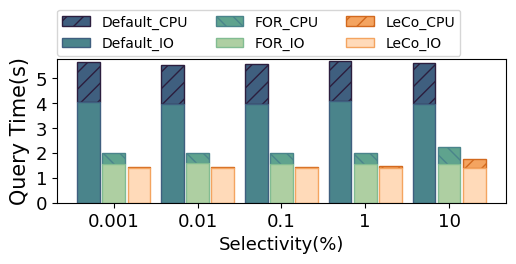

In [36]:
sync_dict = get_data(0, 0,3)
sync_for = get_data(10, 0,3)
sync_leco = get_data(11,0,3)

dict_IO = get_data(0, 0,4)
for_IO = get_data(10, 0,4)
leco_IO = get_data(11, 0,4)
plot_filter_bar(sync_dict, sync_for, sync_leco, dict_IO, for_IO, leco_IO,'filter_bitmap_ml_fb_sync')

In [25]:
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
category_colors = [color_sns[5],color_sns[3],color_sns[1],'sandybrown','peachpuff']
def plot_filter_bar(sync_dict, sync_FOR, sync_LECO, IO_dict, IO_FOR, IO_LECO, titlename,withylabel, withxlabel):
    selectivity = [0.001, 0.01, 0.1, 1, 10]
    mark_style = ['o','v']
    X = np.arange(len(selectivity))+1
    fig, ax = plt.subplots(figsize=(5, 3))
    bar_width = 0.27
    plt.bar(X-0.3, sync_dict-IO_dict,bottom=IO_dict, label = "Default_CPU",width = bar_width, color = color_sns[5], hatch='//',ec=color_sns[7])
    plt.bar(X-0.3, IO_dict, label = "Default_IO",width = bar_width, color = color_sns[4],ec=color_sns[5])
    plt.bar(X, sync_FOR-IO_FOR,bottom=IO_FOR, label = "FOR_CPU",width = bar_width, color = color_sns[3], hatch='\\\\',ec=color_sns[4])
    plt.bar(X, IO_FOR, label = "FOR_IO" ,width = bar_width,  color = color_sns[1], ec=color_sns[2])
    plt.bar(X+0.3, sync_LECO-IO_LECO,bottom=IO_LECO, label = "LeCo_CPU",width = bar_width, color = category_colors[-2], hatch='//',ec='chocolate')
    plt.bar(X+0.3, IO_LECO, label = "LeCo_IO",width = bar_width, color = category_colors[-1],ec=category_colors[-2])
    
#     for i in range(len(sync_LECO)):
# #         plt.annotate(str(int((sync_FOR[i] - sync_LECO[i])*100.0/sync_FOR[i]))+'%' , xy = (X[i], sync_LECO[i]), xytext = (X[i]+0.15, sync_LECO[i]+0.05), fontsize=11)
#         plt.annotate(str(round(sync_FOR[i] / sync_LECO[i], 1))+'x' , xy = (X[i], sync_LECO[i]), xytext = (X[i]+0.15, sync_LECO[i]+0.05), fontsize=11)
    plt.ylim(0, max(sync_dict)+0.1)
    if titlename == 'normal':
        plt.ylim([0,1.7])
        plt.legend(fontsize=9,ncol=3,borderaxespad = 0.1, loc=2)
    plt.xticks(X, selectivity,fontsize=13)
    plt.yticks(fontsize=13)
    if withxlabel:
        plt.xlabel("Selectivity(%)", fontsize = 15)
    if withylabel:
        plt.ylabel("Query Time(s)", fontsize = 15)
    ymajorLocator = MultipleLocator(0.5)
    plt.gca().yaxis.set_major_locator(ymajorLocator)
    plt.title(titlename, fontsize = 18)
    plt.tight_layout()
    plt.savefig('parquet_bitmap_{}.pdf'.format(titlename),dpi=500, transparent=True)
    plt.show()

In [39]:
selectivity = [0.001, 0.01, 0.1, 1, 10]
def get_data(encode, dataset, attri, logname = '/root/parquet_bitmap_new.csv'):
    df = pd.read_csv(logname, delimiter = ',')
    tmp = np.array(df.loc[(df['encoding']==encode) & (df['dataset']==dataset) &(df['selectivity'].isin(selectivity))][attri])
    tmp = np.mean(tmp.reshape([3, -1]),0)
    return tmp

[5.35582102 5.81255968 4.92750117 2.45898585 1.09018379]
[5.21052761 5.52445131 5.3395906  5.33130143 5.28798486]
[5.24255786 5.58127841 5.25386425 4.17835554 1.83619443]


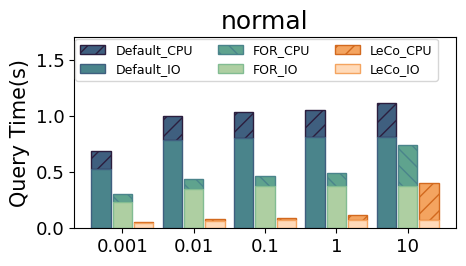

[1.08128895 1.158471   1.14298616 1.05179384 0.91173297]
[1.24838049 1.31752693 1.28488539 1.30280175 1.31823505]
[1.20186294 1.27773314 1.24863042 1.22011201 1.05200437]


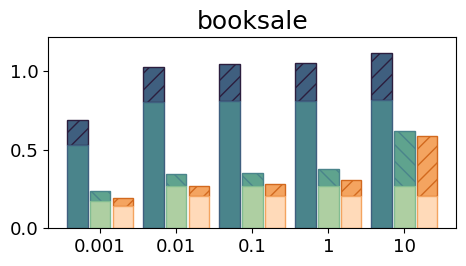

[1.81592844 1.82729021 1.7839033  1.5715883  1.13654255]
[1.73173151 1.68278546 1.6443182  1.65738546 1.61968482]
[1.74922186 1.71045597 1.67205211 1.63665355 1.37943483]


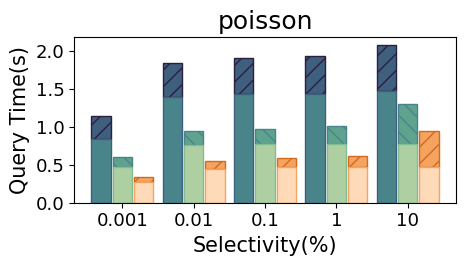

[1.5190615  1.7187184  1.66599866 1.31806726 0.96097424]
[1.62444169 1.64570057 1.7049447  1.69916856 1.69650524]
[1.60179219 1.65942943 1.69691941 1.58200857 1.18557374]


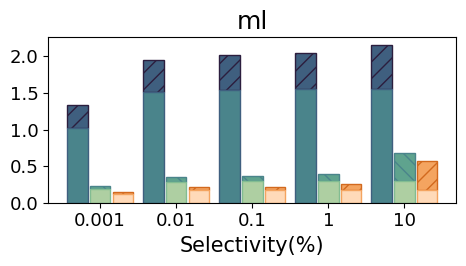

In [27]:
datasets = ['normal_200M_uint32.txt','books_200M_uint32.txt','poisson_timestamps_EVENT_50000_SENSOR_2000_randomdie_OUTER_1000s_INNER_2ms_200M.csv','ml_timestamp_200M.csv']
# datasets = ['normal_200M_uint32.txt']
figname = ['normal','booksale','poisson','ml']
withylabel = [1,0,1,0]
withxlabel = [0,0,1,1]
i=0
for dataset in datasets:
    sync_dict = get_data('DICT', dataset, 'query_time')
    sync_for = get_data('FOR', dataset, 'query_time')
    sync_leco = get_data('LECO', dataset, 'query_time')
    
    dict_cpu = get_data('DICT', dataset, 'query_time_preload')
    for_cpu = get_data('FOR', dataset, 'query_time_preload')
    leco_cpu = get_data('LECO', dataset, 'query_time_preload')
    
    dict_IO = sync_dict - get_data('DICT', dataset, 'query_time_preload')
    for_IO = sync_for - get_data('FOR', dataset, 'query_time_preload')
    leco_IO = sync_leco - get_data('LECO', dataset, 'query_time_preload')
    print(for_cpu/leco_cpu)
    print(for_IO/leco_IO)
    print(sync_for/sync_leco)
    
    plot_filter_bar(sync_dict, sync_for, sync_leco, dict_IO, for_IO, leco_IO,figname[i], withylabel[i], withxlabel[i])
    i+=1

In [40]:
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
category_colors = [color_sns[5],color_sns[3],color_sns[1],'sandybrown','peachpuff']
def plot_zstd_bar(wo_zstd, cpu_wo_zstd, w_zstd, cpu_w_zstd, titlename):
    methods = ['Default','FOR','LeCo']
    X = np.arange(3)+1
    fig, ax = plt.subplots(figsize=(5, 3.3))
    bar_width = 0.4
    plt.bar(X-0.2, cpu_wo_zstd,bottom=wo_zstd - cpu_wo_zstd, label = "Default_CPU",width = bar_width, color = color_sns[3], hatch='\\\\',ec=color_sns[4])
    plt.bar(X-0.2, wo_zstd - cpu_wo_zstd, label = "Default_IO",width = bar_width, color = color_sns[1],ec=color_sns[2])
    plt.bar(X+0.2, cpu_w_zstd,bottom=w_zstd - cpu_w_zstd, label = "ZSTD_CPU",width = bar_width, color = category_colors[-2], hatch='//',ec='chocolate')
    plt.bar(X+0.2, w_zstd - cpu_w_zstd, label = "ZSTD_IO" ,width = bar_width,  color = category_colors[-1], ec=category_colors[-2])
    plt.legend(fontsize=13,ncols = 1,borderaxespad = 0.5)
    plt.xticks(X, methods, fontsize=17)
    plt.yticks(fontsize=13)
    plt.ylabel("Query Time(s)", fontsize = 15)
    ymajorLocator = MultipleLocator(0.5)
    plt.gca().yaxis.set_major_locator(ymajorLocator)
#     plt.title(titlename, fontsize = 18)
    plt.tight_layout()
    plt.savefig('parquet_bitmap_{}.pdf'.format(titlename),dpi=500, transparent=True)
    plt.show()

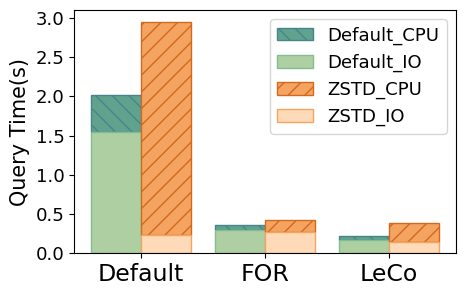

In [41]:
datasets = ['normal_200M_uint32.txt','books_200M_uint32.txt','poisson_timestamps_EVENT_50000_SENSOR_2000_randomdie_OUTER_1000s_INNER_2ms_200M.csv','ml_timestamp_200M.csv']
# datasets = ['normal_200M_uint32.txt']
figname = ['normal','booksale','poisson','ml']
withylabel = [1,0,1,0]
withxlabel = [0,0,1,1]
dataset = 'ml_timestamp_200M.csv'
file_zstd = '/root/parquet_bitmap_zstd.csv'
wo_zstd = []
w_zstd = []
cpu_wo_zstd = []
cpu_w_zstd = []
for method in ['DICT','FOR','LECO']:
    wo_zstd.append(get_data(method, dataset, 'query_time')[2])
    w_zstd.append(get_data(method, dataset, 'query_time',file_zstd)[2])
    cpu_wo_zstd.append(get_data(method, dataset, 'query_time_preload')[2])
    cpu_w_zstd.append(get_data(method, dataset, 'query_time_preload',file_zstd)[2])

plot_zstd_bar(np.array(wo_zstd), np.array(cpu_wo_zstd), np.array(w_zstd), np.array(cpu_w_zstd),'ml_wo_zstd')


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
name = 'zstd_result_new.csv'
encoding_map = {'DICT': 8, 'FOR': 10, 'LECO': 11}
enc_to_label = {'LECO': 'LeCo', 'FOR': 'FOR', 'DICT': 'Default', 'PLAIN': 'Plain'}
encoding_names = []
for enc in encoding_map.keys():
        encoding_names.append(enc_to_label[enc])
df = pd.read_csv(name) 
df = df[df['encoding'] != 'PLAIN']
colors = ['darkseagreen','seagreen','sandybrown']
# print(df)
barWidth = 0.1
cnt = 0
zstd_cr_total = []
for ds in dataset_dict:
    no_zstd_res = df.loc[(df['file'] == ds) & (df['compression'].isnull()), 'size']
    #divide all values in no_zstd_res by 1024
    no_zstd_res = no_zstd_res / 1024 / 1024
    zstd_res = df.loc[(df['file'] == ds) & (df['compression'] == '.zstd'), 'size']
    zstd_res = zstd_res / 1024 / 1024
    no_zstd_enc = df.loc[(df['file'] == ds) & (df['compression'].isnull()), 'encoding']
    zstd_enc = df.loc[(df['file'] == ds) & (df['compression'] == '.zstd'), 'encoding']
    zstd_cr = no_zstd_res.to_numpy().flatten() / zstd_res.to_numpy().flatten()
    zstd_cr_total.extend(zstd_cr)
    # print(no_zstd_res)
    # print(zstd_res)
    # print(no_zstd_enc)
    # print(zstd_enc)

In [8]:
def create_multi_bars(labels, datas, name, zstd_res_total, tick_step=1.5, group_gap=0.15, bar_gap=0):
    codec = ['Default', 'Default-zstd', 'FOR', 'FOR-zstd', 'LeCo', 'LeCo-zstd']
#     category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, len(data)))
    category_colors = ['steelblue','lightsteelblue','seagreen','darkseagreen','sandybrown','peachpuff']
    category_colors = [color_sns[6],color_sns[5],color_sns[3],color_sns[1],'sandybrown','peachpuff']
    ticks = np.arange(len(labels)) * tick_step
    group_num = len(datas)
    group_width = tick_step - group_gap
    bar_span = group_width / group_num
    bar_width = bar_span - bar_gap
    baseline_x = ticks - (group_width - bar_span) / 2
    plt.figure(figsize=(16, 5))

    plt.ylabel('File Size (MB)',fontsize=37)
    for index, y in enumerate(datas):
        plt.bar(baseline_x + index*bar_span, y, bar_width, label =codec[index],color = category_colors[index] )
        
    gap = baseline_x[1] - baseline_x[0]
    for i in range(len(labels)):
        zstd_cr_tmp = zstd_cr_total[(0 + i*3): (3 + i*3)]
        zstd_res_tmp = zstd_res_total[(0 + i*3): (3 + i*3)]
        speedup_xspace, speedup_yspace = -0.4 + i * gap, 20
        for x, y, s in zip([bar_width*r*2 for r in range(len(zstd_res_tmp))], 
                zstd_res_tmp, zstd_cr_tmp):
            plt.text(x + speedup_xspace-0.06, y + speedup_yspace,
                "%.1fx"%(s), fontsize=20)
    plt.legend(fontsize=21)
    # plt.ylim([0,4])
    ax = plt.gca()
    ymajorLocator = MultipleLocator(500)
    ax.yaxis.set_major_locator(ymajorLocator)
    # ymajorLocator = MultipleLocator(1.0)
    # ax.yaxis.set_major_locator(ymajorLocator)
    # ymajorFormatter = FormatStrFormatter('%1.1f')
    # ax.yaxis.set_major_formatter(ymajorFormatter)
#     ax.yaxis.tick_right()
    plt.xlim([min(baseline_x)-0.2, max(baseline_x)+1.5])
    plt.yticks(fontsize=22)
    plt.xticks(ticks, labels, fontsize=30)
    plt.tight_layout()
    plt.savefig(f'zstd_{name}.pdf',dpi=500, transparent=True)
    plt.show()

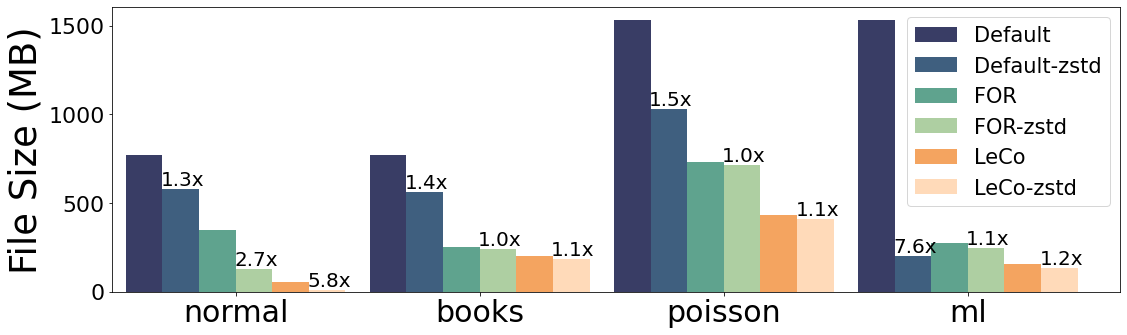

In [9]:
labels = ['normal', 'books', 'poisson', 'ml']
datas = [[], [], [], [], [], []]
zstd_res_total = []
for ds in dataset_dict:
    no_zstd_res = df.loc[(df['file'] == ds) & (df['compression'].isnull()), 'size']
    #divide all values in no_zstd_res by 1024
    no_zstd_res = list(no_zstd_res / 1024 / 1024)
    zstd_res = df.loc[(df['file'] == ds) & (df['compression'] == '.zstd'), 'size']
    zstd_res = list(zstd_res / 1024 / 1024)
    zstd_res_total.extend(zstd_res)
    data = []
    for i in range(len(no_zstd_res)):
        datas[i*2].append(no_zstd_res[i])
        datas[i*2 + 1].append(zstd_res[i])
create_multi_bars(labels, datas, 'total', zstd_res_total)